# 1. Import and setup

In [515]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

from scipy.stats import pearsonr, ttest_ind
from sklearn.decomposition import PCA
from kmodes.kprototypes import KPrototypes
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from yellowbrick.cluster import KElbowVisualizer

import warnings
warnings.filterwarnings('ignore')

In [516]:
# Setting up styling
sns.set(style="darkgrid")
sns.set_palette("flare")

print(sns.color_palette("flare").as_hex())
palette = sns.color_palette("flare").as_hex()
sns.color_palette("flare")

['#e98d6b', '#e3685c', '#d14a61', '#b13c6c', '#8f3371', '#6c2b6d']


[(0.9155979, 0.55210684, 0.42070204),
 (0.888292, 0.40830288, 0.36223756),
 (0.81942908, 0.28911553, 0.38102921),
 (0.69226314, 0.23413578, 0.42480327),
 (0.56041794, 0.19845221, 0.44207535),
 (0.42355299, 0.16934709, 0.42581586)]

In [517]:
RANDOM_STATE=42

In [518]:
# Helper function

"""
Plots histogram and boxplot to compare difference in distribution of given label
- label: the feature to be compared
- title: title of the figure
"""
def plot_mean_difference(df, label, title, colours, features_kde):
    fig, axes = plt.subplots(2, len(features_kde), figsize=(30, 7))
    value = df[label].unique()
    p_vals = []

    for i in range(len(features_kde)):
        feature = features_kde[i]
        for j, val in enumerate(df[label].unique()):
            sns.kdeplot(df[df[label] == val][feature], ax=axes[0, i], fill=True, label=val, color=colours[j])
        axes[0, i].set(ylabel=None)
        axes[0, i].set(xlabel=None)
        axes[0, i].set_title(feature)

        sns.boxplot(ax=axes[1, i], x=label, y=feature, data=df, palette=colours)
        axes[1, i].set(ylabel=None)
        axes[1, i].set(xlabel=None)
        
        t_statistic, p_value = ttest_ind(df[df[label] == value[0]][feature].dropna(),
                                 df[df[label] == value[1]][feature].dropna())
        p_vals.append(p_value)
    axes[0,-1].legend(title=label)

    fig.suptitle(title)
    plt.show()
    return dict(zip(features_kde, p_vals))

"""
Plot coefficient correlation inside a pair plot, used in pair_plot function
"""
def reg_coef(x,y,label=None,color=None,hue=None,**kwargs):
    ax = plt.gca()
    r,p = pearsonr(x,y)
    marker_size = abs(r) * 10000
    ax.scatter([.5], [.5], marker_size, [r], alpha=0.6, cmap="flare",
            vmin=-1, vmax=1, transform=ax.transAxes)
    ax.annotate('r = {:.2f}'.format(r), xy=(0.5,0.5), xycoords='axes fraction', ha='center')
    ax.set_axis_off()

"""
Plot pair grid of bivariate analysis, includes scatter plot and correlation computation
- df: dataframe containing all features
- label: the feature to be compared
- title: title of figure
"""
def pair_plot(df, label, title, colours):
    g = sns.PairGrid(df, hue=label, diag_sharey=False, palette=colours)
    g.map_upper(reg_coef, hue=None)
    g.map_diag(sns.kdeplot, fill=True)
    g.map_lower(sns.scatterplot)

    g.add_legend(adjust_subtitles=True, title=label)
    g.fig.subplots_adjust(top=0.95)
    g.fig.suptitle(title)

    plt.show()

# 2. Read dataset

In [519]:
df = pd.read_csv('../dataset/digital_final_27th_Oct.csv', index_col=0)
df.head()

,hadm_id,alcoholism,gender,anchor_age,deathtime,hematocrit_serum,blood_urea_nitrogen,serum_creatinine,Non_Invasive_Blood_Pressure_systolic,Non_Invasive_Blood_Pressure_diastolic,white_bloodcells,Glucose_serum,platelet_PLT,Prothrombin_time,aminotransferase_ALT,Total_Bilirubin,Anion_gap,Heart_rate_Alarm_High,Heart_rate_Alarm_low,earliest_weight_kg
0,22698313,0,F,89,2164-09-06T02:23:00,19.9,40.0,1.0,107.0,54.0,39.7,240.0,183.0,16.4,28.0,0.4,23.0,130.0,40.0,56.0
1,29562026,0,F,84,NaN,22.5,26.0,0.7,118.0,96.0,7.1,116.0,160.0,17.4,27.0,2.8,14.0,120.0,50.0,78.1
2,21607777,0,F,37,NaN,29.5,31.0,2.0,76.0,48.0,18.6,106.0,239.0,15.8,168.0,1.1,13.0,150.0,40.0,52.2
3,25233292,0,M,47,NaN,29.9,97.0,6.8,137.0,85.0,9.7,110.0,137.0,12.7,473.0,0.4,24.0,130.0,50.0,103.4
4,24214772,0,M,22,NaN,43.0,11.0,0.9,148.0,80.0,18.1,117.0,249.0,13.2,24.0,0.4,11.0,140.0,40.0,101.0


In [520]:
# Label mortality
df['mortality'] = df['deathtime'].apply(lambda x: 'Survive' if x is np.nan else 'Dead')
df['mortality'].value_counts()

mortality
Survive    249
Dead        62
Name: count, dtype: int64

In [521]:
df.columns

Index(['hadm_id', 'alcoholism', 'gender', 'anchor_age', 'deathtime',
       'hematocrit_serum', 'blood_urea_nitrogen', 'serum_creatinine',
       'Non_Invasive_Blood_Pressure_systolic',
       'Non_Invasive_Blood_Pressure_diastolic', 'white_bloodcells',
       'Glucose_serum', 'platelet_PLT', 'Prothrombin_time',
       'aminotransferase_ALT', 'Total_Bilirubin', 'Anion_gap',
       'Heart_rate_Alarm_High', 'Heart_rate_Alarm_low', 'earliest_weight_kg',
       'mortality'],
      dtype='object')

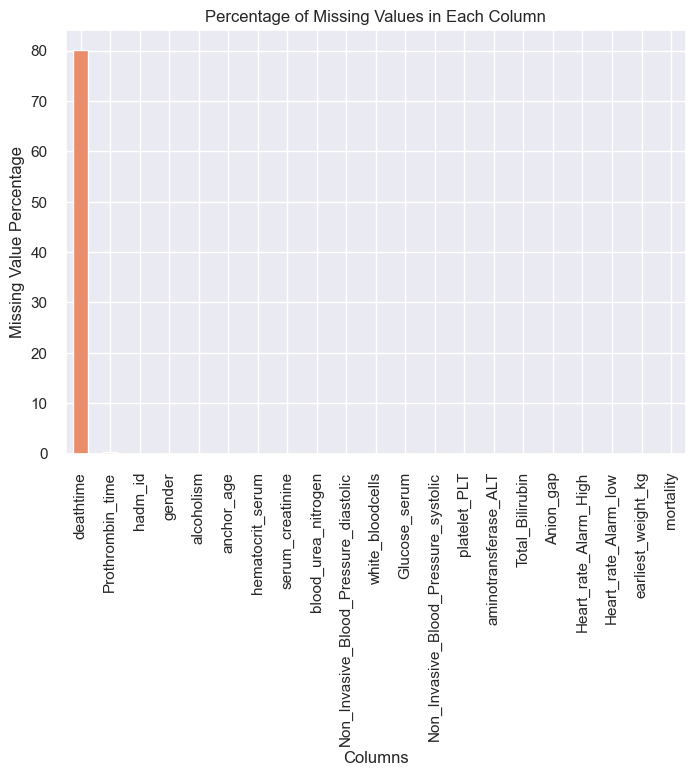

In [522]:
# Datatype and missing value information
missing_percentage = (df.isnull().sum() / df.shape[0]) * 100
    
missing_percentage.sort_values(ascending=False).plot(kind='bar', color=palette[0])
plt.xlabel('Columns')
plt.ylabel('Missing Value Percentage')
plt.title('Percentage of Missing Values in Each Column')
plt.show()

In [523]:
missing_columns = missing_percentage.sort_values(ascending=False)[:1]
missing_columns

deathtime    80.064309
dtype: float64

In [524]:
df_clean = df.drop(missing_columns.index, axis=1)
df_clean.head()

,hadm_id,alcoholism,gender,anchor_age,hematocrit_serum,blood_urea_nitrogen,serum_creatinine,Non_Invasive_Blood_Pressure_systolic,Non_Invasive_Blood_Pressure_diastolic,white_bloodcells,Glucose_serum,platelet_PLT,Prothrombin_time,aminotransferase_ALT,Total_Bilirubin,Anion_gap,Heart_rate_Alarm_High,Heart_rate_Alarm_low,earliest_weight_kg,mortality
0,22698313,0,F,89,19.9,40.0,1.0,107.0,54.0,39.7,240.0,183.0,16.4,28.0,0.4,23.0,130.0,40.0,56.0,Dead
1,29562026,0,F,84,22.5,26.0,0.7,118.0,96.0,7.1,116.0,160.0,17.4,27.0,2.8,14.0,120.0,50.0,78.1,Survive
2,21607777,0,F,37,29.5,31.0,2.0,76.0,48.0,18.6,106.0,239.0,15.8,168.0,1.1,13.0,150.0,40.0,52.2,Survive
3,25233292,0,M,47,29.9,97.0,6.8,137.0,85.0,9.7,110.0,137.0,12.7,473.0,0.4,24.0,130.0,50.0,103.4,Survive
4,24214772,0,M,22,43.0,11.0,0.9,148.0,80.0,18.1,117.0,249.0,13.2,24.0,0.4,11.0,140.0,40.0,101.0,Survive


In [525]:
(df_clean.isnull().sum(axis=1) / df_clean.shape[1]).value_counts().sort_index()

0.00    310
0.05      1
Name: count, dtype: int64

In [526]:
# Statistical description of numerical features
df_clean.describe(include=[np.number]).round(2)

,hadm_id,alcoholism,anchor_age,hematocrit_serum,blood_urea_nitrogen,serum_creatinine,Non_Invasive_Blood_Pressure_systolic,Non_Invasive_Blood_Pressure_diastolic,white_bloodcells,Glucose_serum,platelet_PLT,Prothrombin_time,aminotransferase_ALT,Total_Bilirubin,Anion_gap,Heart_rate_Alarm_High,Heart_rate_Alarm_low,earliest_weight_kg
count,311.00,311.00,311.00,311.00,311.00,311.00,311.00,311.00,311.00,311.00,311.00,310.00,311.00,311.00,311.00,311.00,311.00,311.00
mean,24968797.93,0.13,59.98,32.45,31.84,1.81,123.07,70.53,13.82,152.17,221.18,17.75,195.26,2.76,15.94,125.37,52.75,80.41
std,2848398.04,0.34,17.64,7.46,27.77,1.89,27.23,19.79,11.79,92.15,142.87,10.48,641.63,5.56,5.38,10.08,5.98,22.56
min,20009550.00,0.00,22.00,16.60,1.00,0.10,57.00,25.00,0.20,36.00,6.00,8.80,2.00,0.00,5.00,100.00,40.00,32.00
25%,22547487.50,0.00,48.00,27.30,14.00,0.80,103.00,56.00,7.20,103.00,117.50,13.40,18.00,0.50,13.00,120.00,50.00,64.95
50%,24961541.00,0.00,61.00,31.40,23.00,1.10,121.00,68.00,11.30,133.00,198.00,15.40,35.00,1.00,15.00,120.00,50.00,78.00
75%,27380606.50,0.00,73.00,37.10,40.50,2.10,140.50,83.00,17.60,168.00,290.00,18.58,106.00,2.50,18.00,130.00,60.00,93.00
max,29995505.00,1.00,91.00,54.30,163.00,20.40,259.00,142.00,156.20,817.00,942.00,150.00,8805.00,53.10,44.00,170.00,90.00,166.60


In [527]:
# Statistical description of categorical features
df_clean.describe(include=[np.object_])

,gender,mortality
count,311,311
unique,2,2
top,M,Survive
freq,163,249


In [528]:
# Number of distinct patients
print('Number of distinct patients: ', df_clean.hadm_id.unique().shape[0])
print('Number of duplication', len(df_clean[df_clean.duplicated()]))

Number of distinct patients:  311
Number of duplication 0


In [529]:
df_clean.columns

Index(['hadm_id', 'alcoholism', 'gender', 'anchor_age', 'hematocrit_serum',
       'blood_urea_nitrogen', 'serum_creatinine',
       'Non_Invasive_Blood_Pressure_systolic',
       'Non_Invasive_Blood_Pressure_diastolic', 'white_bloodcells',
       'Glucose_serum', 'platelet_PLT', 'Prothrombin_time',
       'aminotransferase_ALT', 'Total_Bilirubin', 'Anion_gap',
       'Heart_rate_Alarm_High', 'Heart_rate_Alarm_low', 'earliest_weight_kg',
       'mortality'],
      dtype='object')

In [530]:
features_kde = ['hematocrit_serum',
       'blood_urea_nitrogen', 'serum_creatinine',
       'Non_Invasive_Blood_Pressure_systolic',
       'Non_Invasive_Blood_Pressure_diastolic', 'white_bloodcells',
       'Glucose_serum', 'platelet_PLT', 'Anion_gap', 'Heart_rate_Alarm_High',
       'Heart_rate_Alarm_low', 'earliest_weight_kg']

# 4. Preprocessing

In [531]:
# Drop gender
X = df_clean.drop(['hadm_id', 'gender', 'mortality'], axis=1)
X.head()

,alcoholism,anchor_age,hematocrit_serum,blood_urea_nitrogen,serum_creatinine,Non_Invasive_Blood_Pressure_systolic,Non_Invasive_Blood_Pressure_diastolic,white_bloodcells,Glucose_serum,platelet_PLT,Prothrombin_time,aminotransferase_ALT,Total_Bilirubin,Anion_gap,Heart_rate_Alarm_High,Heart_rate_Alarm_low,earliest_weight_kg
0,0,89,19.9,40.0,1.0,107.0,54.0,39.7,240.0,183.0,16.4,28.0,0.4,23.0,130.0,40.0,56.0
1,0,84,22.5,26.0,0.7,118.0,96.0,7.1,116.0,160.0,17.4,27.0,2.8,14.0,120.0,50.0,78.1
2,0,37,29.5,31.0,2.0,76.0,48.0,18.6,106.0,239.0,15.8,168.0,1.1,13.0,150.0,40.0,52.2
3,0,47,29.9,97.0,6.8,137.0,85.0,9.7,110.0,137.0,12.7,473.0,0.4,24.0,130.0,50.0,103.4
4,0,22,43.0,11.0,0.9,148.0,80.0,18.1,117.0,249.0,13.2,24.0,0.4,11.0,140.0,40.0,101.0


In [532]:
X['gender'] = LabelEncoder().fit_transform(df_clean['gender'])
# X['mortality'] = LabelEncoder().fit_transform(df_clean['mortality'])
X.head()

,alcoholism,anchor_age,hematocrit_serum,blood_urea_nitrogen,serum_creatinine,Non_Invasive_Blood_Pressure_systolic,Non_Invasive_Blood_Pressure_diastolic,white_bloodcells,Glucose_serum,platelet_PLT,Prothrombin_time,aminotransferase_ALT,Total_Bilirubin,Anion_gap,Heart_rate_Alarm_High,Heart_rate_Alarm_low,earliest_weight_kg,gender
0,0,89,19.9,40.0,1.0,107.0,54.0,39.7,240.0,183.0,16.4,28.0,0.4,23.0,130.0,40.0,56.0,0
1,0,84,22.5,26.0,0.7,118.0,96.0,7.1,116.0,160.0,17.4,27.0,2.8,14.0,120.0,50.0,78.1,0
2,0,37,29.5,31.0,2.0,76.0,48.0,18.6,106.0,239.0,15.8,168.0,1.1,13.0,150.0,40.0,52.2,0
3,0,47,29.9,97.0,6.8,137.0,85.0,9.7,110.0,137.0,12.7,473.0,0.4,24.0,130.0,50.0,103.4,1
4,0,22,43.0,11.0,0.9,148.0,80.0,18.1,117.0,249.0,13.2,24.0,0.4,11.0,140.0,40.0,101.0,1


In [533]:
X = X.fillna(X.median())

In [534]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled

array([[-0.38418938,  1.6476941 , -1.68594643, ..., -2.13649639,
        -1.08353743, -1.04945288],
       [-0.38418938,  1.36382923, -1.33676957, ..., -0.46070729,
        -0.10244702, -1.04945288],
       [-0.38418938, -1.30450056, -0.39667804, ..., -2.13649639,
        -1.25223171, -1.04945288],
       ...,
       [-0.38418938,  0.05805082,  0.00621834, ..., -0.46070729,
        -0.09356837,  0.95287746],
       [-0.38418938,  1.30705625, -0.0340713 , ..., -0.46070729,
        -1.17232389, -1.04945288],
       [-0.38418938, -0.56645189, -1.04131223, ..., -2.13649639,
         0.03073268,  0.95287746]])

One of the feature of standard scaling is that, we can detect outliers by filtering values `abs(x) > 3.5`. We choose number `3.5` as it does not discard huge amount of data while still being reasonable number for an outlier.

In [535]:
# Outliers detection for each features
X_cleaned = pd.DataFrame(X_scaled)
X_cleaned = X_scaled[(np.abs(X_scaled) < 3.5).all(axis=1)]
df_clean = df_clean[(np.abs(X_scaled) < 3.5).all(axis=1)].reset_index(drop=True)
X = X[(np.abs(X_scaled) < 3.5).all(axis=1)]
print("Number of cleaned record is", len(X_cleaned))
X_cleaned

Number of cleaned record is 277


array([[-0.38418938,  1.6476941 , -1.68594643, ..., -2.13649639,
        -1.08353743, -1.04945288],
       [-0.38418938,  1.36382923, -1.33676957, ..., -0.46070729,
        -0.10244702, -1.04945288],
       [-0.38418938, -1.30450056, -0.39667804, ..., -2.13649639,
        -1.25223171, -1.04945288],
       ...,
       [ 2.60288302, -1.53159245,  0.77172144, ...,  1.2150818 ,
         0.11507982,  0.95287746],
       [-0.38418938,  0.22836975, -0.18179997, ...,  1.2150818 ,
         0.43027176,  0.95287746],
       [-0.38418938,  1.30705625, -0.0340713 , ..., -0.46070729,
        -1.17232389, -1.04945288]])

In [536]:
pca = PCA(n_components=3)
principal_components = pca.fit_transform(X_cleaned)

# Create a DataFrame for visualization
X_pca = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2', 'PC3'])
X_pca

,PC1,PC2,PC3
0,-2.070102,-0.156330,-1.599677
1,-0.645369,-0.749289,-0.363889
2,-1.676633,-0.685740,0.591615
3,0.920698,3.422310,-1.241765
4,2.276157,-0.263158,0.172835
...,...,...,...
272,-1.289346,1.093397,-1.120301
273,1.073623,-1.517247,-0.558911
274,2.041130,1.093332,2.402344
275,0.651499,2.394823,-1.451179


# 5. K-Means


## 5.1. Finding optimal cluster

#### Manual

In [537]:
wcss = []
ss = []

# Run algorithm through different number of clusters
for i in range(2, 15):
    kmeans = KMeans(n_clusters=i, random_state=RANDOM_STATE)
    kmeans.fit(X_cleaned)

    # Record within cluster sum of squares
    wcss.append(kmeans.inertia_)

    # Record silhouette score
    sil_score = silhouette_score(X_cleaned, kmeans.labels_)
    ss.append(sil_score)

In [538]:
total_var = np.sum(np.var(X, axis=0)) * X.shape[0]
total_var

24657313.47501805

In [539]:
var_explained = (1 - (np.array(wcss) / np.sum(wcss))) * 100
var_explained

array([89.89249872, 90.69307458, 91.37260127, 91.84317406, 92.10100693,
       92.39506126, 92.63242137, 92.74231666, 92.97615583, 93.12852651,
       93.23657705, 93.38890755, 93.59767822])

Text(0.5, 1.0, 'Total Variance Explained')

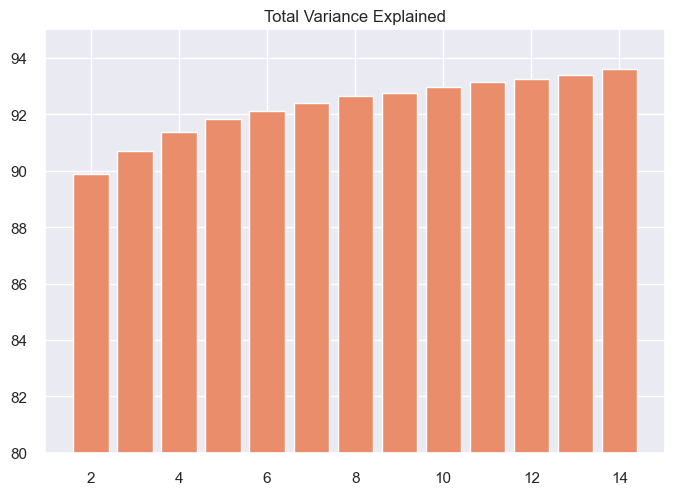

In [540]:
plt.bar(range(2,15), var_explained)
plt.ylim((80,95))
plt.title("Total Variance Explained")

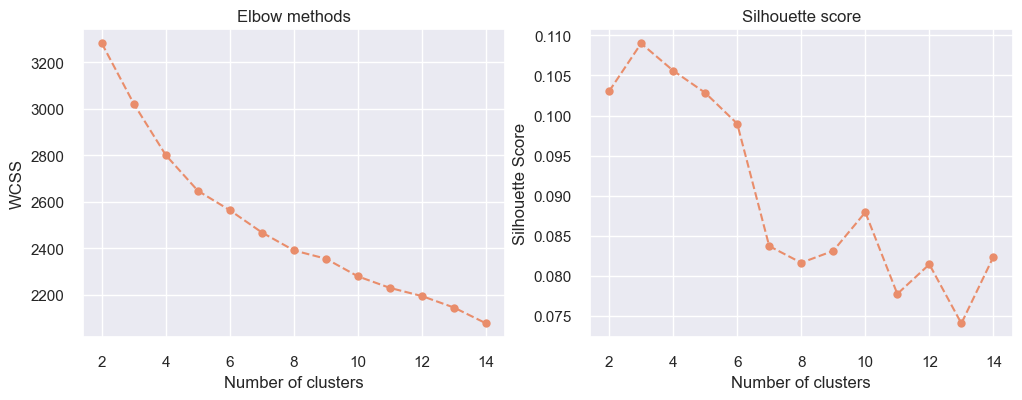

In [541]:
# Plot Elbow graph
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(range(2, 15), wcss, marker='o', linestyle='--')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.title('Elbow methods')

# Plot Silhouette Score graph
plt.subplot(1, 2, 2)
plt.plot(range(2, 15), ss, marker='o', linestyle='--')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette score')

plt.show()

#### On Yellowbrick

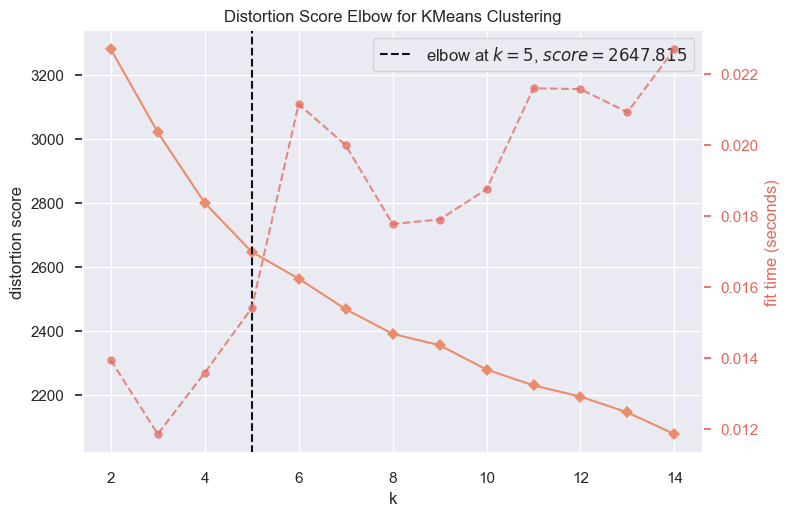

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [486]:
model = KMeans(random_state=RANDOM_STATE)
visualizer = KElbowVisualizer(model, k=(2,15))
# Fit and show the performance with dataset
visualizer.fit(X_cleaned)
visualizer.show()

In [487]:
kmeans_cluster = 5

## 5.2. Fitting the model

In [490]:
# Fit model
kmeans = KMeans(n_clusters=kmeans_cluster, random_state=RANDOM_STATE)
kmeans.fit(X_cleaned)

df_clean['cluster'] = kmeans.labels_.astype(object)
X_pca['cluster'] = df_clean['cluster']
df_clean.head()

,hadm_id,alcoholism,gender,anchor_age,hematocrit_serum,blood_urea_nitrogen,serum_creatinine,Non_Invasive_Blood_Pressure_systolic,Non_Invasive_Blood_Pressure_diastolic,white_bloodcells,...,platelet_PLT,Prothrombin_time,aminotransferase_ALT,Total_Bilirubin,Anion_gap,Heart_rate_Alarm_High,Heart_rate_Alarm_low,earliest_weight_kg,mortality,cluster
0,22698313,0,F,89,19.9,40.0,1.0,107.0,54.0,39.7,...,183.0,16.4,28.0,0.4,23.0,130.0,40.0,56.0,Dead,4
1,29562026,0,F,84,22.5,26.0,0.7,118.0,96.0,7.1,...,160.0,17.4,27.0,2.8,14.0,120.0,50.0,78.1,Survive,4
2,21607777,0,F,37,29.5,31.0,2.0,76.0,48.0,18.6,...,239.0,15.8,168.0,1.1,13.0,150.0,40.0,52.2,Survive,4
3,25233292,0,M,47,29.9,97.0,6.8,137.0,85.0,9.7,...,137.0,12.7,473.0,0.4,24.0,130.0,50.0,103.4,Survive,3
4,24214772,0,M,22,43.0,11.0,0.9,148.0,80.0,18.1,...,249.0,13.2,24.0,0.4,11.0,140.0,40.0,101.0,Survive,1


In [491]:
# Evaluation metric
wcss = kmeans.inertia_
ss = silhouette_score(X_cleaned, kmeans.labels_)

print(f"Fitting model with {kmeans_cluster} clusters, resulting on {round(wcss,2)} WCSS and {round(ss,2)} silhouette score")

Fitting model with 5 clusters, resulting on 2647.81 WCSS and 0.1 silhouette score


In [492]:
# Center of clusters
kmeans_center = scaler.inverse_transform(kmeans.cluster_centers_)
pd.DataFrame(dict(zip(df_clean.columns, kmeans_center.T)))

,hadm_id,alcoholism,gender,anchor_age,hematocrit_serum,blood_urea_nitrogen,serum_creatinine,Non_Invasive_Blood_Pressure_systolic,Non_Invasive_Blood_Pressure_diastolic,white_bloodcells,Glucose_serum,platelet_PLT,Prothrombin_time,aminotransferase_ALT,Total_Bilirubin,Anion_gap,Heart_rate_Alarm_High,Heart_rate_Alarm_low
0,2.775558e-17,64.308824,30.898529,25.088235,1.351471,108.544118,61.176471,12.200000,138.823529,227.308824,16.960294,153.882353,1.823529,14.294118,123.235294,52.205882,91.108824,0.955882
1,2.775558e-17,57.545455,39.658182,27.781818,1.738182,151.000000,92.472727,14.061818,156.400000,214.290909,16.210909,113.272727,2.016364,16.072727,126.545455,52.000000,83.083636,0.690909
2,1.000000e+00,47.424242,33.963636,22.969697,1.390909,123.848485,77.606061,11.257576,150.242424,143.909091,17.103030,137.090909,4.272727,16.303030,126.363636,54.242424,81.651515,0.606061
3,4.166667e-02,65.625000,27.304167,84.125000,4.708333,116.375000,60.541667,14.950000,155.750000,173.916667,19.687500,102.166667,3.008333,18.875000,122.916667,52.083333,88.179167,0.708333
4,2.775558e-17,62.969072,30.516495,21.010309,1.121649,117.257732,64.288660,13.355670,133.350515,243.969072,15.877320,106.020619,1.902062,14.432990,125.051546,52.835052,65.854639,0.020619


# 5. DBSCAN

In [493]:
# Applying DBScan
dbscan = DBSCAN(eps=3)
clusters = dbscan.fit_predict(X_cleaned)

df_clean['DB_cluster'] = clusters
X_pca['DB_cluster'] = clusters
df_clean['DB_cluster'].value_counts()

DB_cluster
 0    185
-1     73
 1     19
Name: count, dtype: int64

In [494]:
db_cluster = 3

# K-Prototypes

In [495]:
# Drop gender
X2 = df_clean.drop(['hadm_id', 'gender', 'mortality', 'alcoholism', 'cluster', 'DB_cluster'], axis=1)
X2 = X2.fillna(X2.median())
X2.head()

,anchor_age,hematocrit_serum,blood_urea_nitrogen,serum_creatinine,Non_Invasive_Blood_Pressure_systolic,Non_Invasive_Blood_Pressure_diastolic,white_bloodcells,Glucose_serum,platelet_PLT,Prothrombin_time,aminotransferase_ALT,Total_Bilirubin,Anion_gap,Heart_rate_Alarm_High,Heart_rate_Alarm_low,earliest_weight_kg
0,89,19.9,40.0,1.0,107.0,54.0,39.7,240.0,183.0,16.4,28.0,0.4,23.0,130.0,40.0,56.0
1,84,22.5,26.0,0.7,118.0,96.0,7.1,116.0,160.0,17.4,27.0,2.8,14.0,120.0,50.0,78.1
2,37,29.5,31.0,2.0,76.0,48.0,18.6,106.0,239.0,15.8,168.0,1.1,13.0,150.0,40.0,52.2
3,47,29.9,97.0,6.8,137.0,85.0,9.7,110.0,137.0,12.7,473.0,0.4,24.0,130.0,50.0,103.4
4,22,43.0,11.0,0.9,148.0,80.0,18.1,117.0,249.0,13.2,24.0,0.4,11.0,140.0,40.0,101.0


In [496]:
scaler2 = StandardScaler()
X_scaled2 = scaler2.fit_transform(X2)
X_scaled2

array([[ 1.61182812, -1.72373231,  0.46604499, ...,  0.53251352,
        -2.23506412, -1.08963869],
       [ 1.32806278, -1.36966466, -0.13023428, ..., -0.50626285,
        -0.46363991, -0.05573427],
       [-1.33933144, -0.41640559,  0.0827226 , ...,  2.61006627,
        -2.23506412, -1.26741411],
       ...,
       [-1.56634371,  0.76835926,  0.12531398, ..., -0.50626285,
         1.3077843 ,  0.17350246],
       [ 0.19300141, -0.1985178 ,  2.04192594, ..., -0.50626285,
         1.3077843 ,  0.5056618 ],
       [ 1.27130971, -0.04871995, -0.68392218, ..., -0.50626285,
        -0.46363991, -1.1832047 ]])

In [497]:
X_scaled2 = np.c_[X_scaled2, X['gender'], X['alcoholism']]

In [498]:
costs = []
n_clusters = []
ss = []

for i in range(2, 15):
    kproto = KPrototypes(n_clusters=i, random_state=RANDOM_STATE)
    clusters = kproto.fit_predict(X_scaled2, categorical=[16,17])
    
    costs.append(kproto.cost_)
    n_clusters.append(i)

    # Record silhouette score
    sil_score = silhouette_score(X_scaled2, clusters)
    ss.append(sil_score)

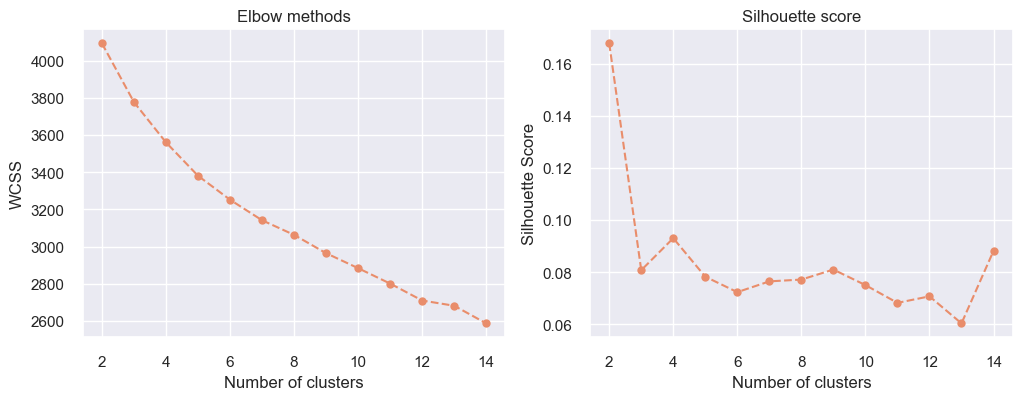

In [499]:
# Plot Elbow graph
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(range(2, 15), costs, marker='o', linestyle='--')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.title('Elbow methods')

# Plot Silhouette Score graph
plt.subplot(1, 2, 2)
plt.plot(range(2, 15), ss, marker='o', linestyle='--')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette score')

plt.show()

In [500]:
proto_cluster = 4

In [501]:
kproto = KPrototypes(n_clusters=proto_cluster, random_state=RANDOM_STATE)
df_clean['proto_cluster'] = kproto.fit_predict(X_scaled2, categorical=[16,17])
X_pca['proto_cluster'] = df_clean['proto_cluster']

In [509]:
X2.shape

(277, 16)

In [505]:
kproto._enc_cluster_centroids[1]

array([[1, 0],
       [1, 0],
       [0, 0],
       [1, 0]], dtype=object)

In [508]:
scaler2.inverse_transform(kproto._enc_cluster_centroids[0])

array([[ 60.20652174,  38.59347826,  24.08695652,   1.20326087,
        139.68478261,  83.19565217,  15.43369565, 171.63043478,
        278.45652174,  14.88152174, 109.16304348,   1.49673913,
         15.94565217, 126.73913043,  53.15217391,  85.90217391],
       [ 47.11764706,  29.81764706,  36.23529412,   2.02941176,
        117.64705882,  70.        ,  12.56470588, 139.41176471,
        134.88235294,  20.95294118, 709.52941176,  10.37647059,
         20.29411765, 126.76470588,  50.88235294,  82.95294118],
       [ 60.71544715,  29.55284553,  19.64227642,   1.04634146,
        112.08943089,  63.89430894,   9.89674797, 125.04065041,
        187.93495935,  16.15406504,  76.70731707,   2.02276423,
         13.16260163, 123.53658537,  52.92682927,  73.35853659],
       [ 66.17777778,  29.46666667,  62.24444444,   4.02888889,
        117.82222222,  62.06666667,  17.28888889, 136.28888889,
        195.64444444,  20.20888889,  53.64444444,   1.54888889,
         18.13333333, 124.        ,  

In [510]:
pd.DataFrame(np.c_[scaler2.inverse_transform(kproto._enc_cluster_centroids[0]), kproto._enc_cluster_centroids[1]],
            columns=list(X2.columns)+['gender', 'alcoholism'])

,anchor_age,hematocrit_serum,blood_urea_nitrogen,serum_creatinine,Non_Invasive_Blood_Pressure_systolic,Non_Invasive_Blood_Pressure_diastolic,white_bloodcells,Glucose_serum,platelet_PLT,Prothrombin_time,aminotransferase_ALT,Total_Bilirubin,Anion_gap,Heart_rate_Alarm_High,Heart_rate_Alarm_low,earliest_weight_kg,gender,alcoholism
0,60.206522,38.593478,24.086957,1.203261,139.684783,83.195652,15.433696,171.630435,278.456522,14.881522,109.163043,1.496739,15.945652,126.73913,53.152174,85.902174,1,0
1,47.117647,29.817647,36.235294,2.029412,117.647059,70.0,12.564706,139.411765,134.882353,20.952941,709.529412,10.376471,20.294118,126.764706,50.882353,82.952941,1,0
2,60.715447,29.552846,19.642276,1.046341,112.089431,63.894309,9.896748,125.04065,187.934959,16.154065,76.707317,2.022764,13.162602,123.536585,52.926829,73.358537,0,0
3,66.177778,29.466667,62.244444,4.028889,117.822222,62.066667,17.288889,136.288889,195.644444,20.208889,53.644444,1.548889,18.133333,124.0,51.333333,80.608889,1,0


# Result

In [419]:
def stat_cum(cluster, clusters):
    cluster0 = df_clean[clusters == cluster]
    mort_rate = round(100* len(cluster0[cluster0.mortality == 'Dead']) / len(cluster0),2)
    print(f"Percentage of women and men (respectively) {round(100 * sum(cluster0.gender == 'F') / len(cluster0),2)} and {round(100 * sum(cluster0.gender == 'M') / len(cluster0),2)}")
    print(f"Mortality rate is {mort_rate}")
    display(round(cluster0.describe(),2))
    return cluster0.describe().loc['mean',:], mort_rate

## Value Counts

In [380]:
df_clean['cluster'].value_counts()

cluster
4    97
0    68
1    55
2    33
3    24
Name: count, dtype: int64

In [381]:
df_clean['DB_cluster'].value_counts()

DB_cluster
 0    185
-1     73
 1     19
Name: count, dtype: int64

In [382]:
df_clean['proto_cluster'].value_counts()

proto_cluster
0    120
2     94
3     41
1     22
Name: count, dtype: int64

## Statistics

In [420]:
stats = pd.DataFrame(index=list(df_clean.columns) + ['mortality_rate'],
                     columns=[])

In [429]:
for i in range(kmeans_cluster):
    print("====================== Cluster %s =========================" % (i))
    kmeans_result, mort_rate = stat_cum(i, df_clean.cluster)
    stats["Kmeans" + str(i)] = 0
    stats.loc[kmeans_result.index, "Kmeans" + str(i)] = kmeans_result.values
    stats.loc['mortality_rate', "Kmeans" + str(i)] = mort_rate

====================== Cluster 0 =========================
Percentage of women and men (respectively) 4.41 and 95.59
Mortality rate is 17.65


,hadm_id,alcoholism,anchor_age,hematocrit_serum,blood_urea_nitrogen,serum_creatinine,Non_Invasive_Blood_Pressure_systolic,Non_Invasive_Blood_Pressure_diastolic,white_bloodcells,Glucose_serum,platelet_PLT,Prothrombin_time,aminotransferase_ALT,Total_Bilirubin,Anion_gap,Heart_rate_Alarm_High,Heart_rate_Alarm_low,earliest_weight_kg,DB_cluster,proto_cluster
count,68.00,68.0,68.00,68.00,68.00,68.00,68.00,68.00,68.00,68.00,68.00,68.00,68.00,68.00,68.00,68.00,68.00,68.00,68.00,68.00
mean,25146441.57,0.0,64.31,30.90,25.09,1.35,108.54,61.18,12.20,138.82,227.31,16.96,153.88,1.82,14.29,123.24,52.21,91.11,-0.18,0.74
std,2863647.45,0.0,15.64,6.12,12.92,0.61,21.11,13.60,9.25,62.73,150.53,5.14,330.98,2.20,3.54,9.21,5.49,21.44,0.38,0.99
min,20084622.00,0.0,23.00,16.70,6.00,0.50,57.00,35.00,0.30,57.00,6.00,10.30,5.00,0.00,5.00,100.00,40.00,55.50,-1.00,0.00
25%,23052297.25,0.0,56.75,26.58,15.00,0.90,94.75,50.00,5.98,100.00,116.50,13.40,18.00,0.57,12.00,120.00,50.00,76.22,0.00,0.00
50%,24839396.00,0.0,68.00,30.90,21.00,1.20,107.50,59.00,8.95,119.00,197.50,15.85,42.50,1.05,14.00,120.00,50.00,85.65,0.00,0.00
75%,27518045.50,0.0,73.00,34.28,36.00,1.70,121.50,70.00,17.42,162.75,290.50,19.02,106.50,2.08,16.00,122.50,60.00,104.22,0.00,2.00
max,29995505.00,0.0,91.00,45.90,59.00,3.50,154.00,98.00,48.60,450.00,645.00,41.90,1789.00,11.20,26.00,150.00,60.00,149.00,0.00,3.00


====================== Cluster 1 =========================
Percentage of women and men (respectively) 30.91 and 69.09
Mortality rate is 20.0


,hadm_id,alcoholism,anchor_age,hematocrit_serum,blood_urea_nitrogen,serum_creatinine,Non_Invasive_Blood_Pressure_systolic,Non_Invasive_Blood_Pressure_diastolic,white_bloodcells,Glucose_serum,platelet_PLT,Prothrombin_time,aminotransferase_ALT,Total_Bilirubin,Anion_gap,Heart_rate_Alarm_High,Heart_rate_Alarm_low,earliest_weight_kg,DB_cluster,proto_cluster
count,55.00,55.0,55.00,55.00,55.00,55.00,55.00,55.00,55.00,55.00,55.00,55.00,55.00,55.00,55.00,55.00,55.00,55.00,55.00,55.00
mean,24771393.38,0.0,57.55,39.66,27.78,1.74,151.00,92.47,14.06,156.40,214.29,16.21,113.27,2.02,16.07,126.55,52.00,83.08,-0.33,1.95
std,2807792.83,0.0,17.76,7.34,16.98,1.57,22.18,16.17,6.48,78.13,94.69,6.37,194.93,2.61,3.94,10.36,6.13,21.44,0.47,0.62
min,20009550.00,0.0,22.00,23.20,4.00,0.40,108.00,59.00,2.90,45.00,9.00,9.70,2.00,0.20,6.00,120.00,40.00,42.00,-1.00,0.00
25%,22557456.00,0.0,48.00,34.05,15.00,0.90,134.00,81.50,9.05,106.50,152.00,13.10,21.50,0.60,14.00,120.00,50.00,69.75,-1.00,2.00
50%,24486475.00,0.0,61.00,40.10,23.00,1.30,148.00,92.00,13.70,138.00,214.00,14.50,42.00,1.00,16.00,120.00,50.00,81.40,0.00,2.00
75%,27164389.00,0.0,69.00,45.15,38.00,2.05,163.00,100.00,18.00,171.00,270.50,16.70,89.00,2.05,19.00,130.00,57.50,93.80,0.00,2.00
max,29955825.00,0.0,91.00,53.20,71.00,7.90,201.00,137.00,29.30,464.00,485.00,49.00,1201.00,12.60,25.00,160.00,70.00,154.50,0.00,3.00


====================== Cluster 2 =========================
Percentage of women and men (respectively) 39.39 and 60.61
Mortality rate is 9.09


,hadm_id,alcoholism,anchor_age,hematocrit_serum,blood_urea_nitrogen,serum_creatinine,Non_Invasive_Blood_Pressure_systolic,Non_Invasive_Blood_Pressure_diastolic,white_bloodcells,Glucose_serum,platelet_PLT,Prothrombin_time,aminotransferase_ALT,Total_Bilirubin,Anion_gap,Heart_rate_Alarm_High,Heart_rate_Alarm_low,earliest_weight_kg,DB_cluster,proto_cluster
count,33.00,33.0,33.00,33.00,33.00,33.00,33.00,33.00,33.00,33.00,33.00,33.00,33.00,33.00,33.00,33.00,33.00,33.00,33.00,33.00
mean,25531823.73,1.0,47.42,33.96,22.97,1.39,123.85,77.61,11.26,150.24,143.91,17.10,137.09,4.27,16.30,126.36,54.24,81.65,0.15,1.15
std,3019496.64,0.0,11.44,8.36,15.75,1.08,26.27,19.86,5.44,63.25,104.22,5.24,336.70,5.32,6.64,8.77,5.61,17.62,1.00,1.03
min,20561449.00,1.0,27.00,16.90,3.00,0.40,73.00,45.00,2.90,66.00,18.00,11.00,7.00,0.20,7.00,120.00,50.00,51.90,-1.00,0.00
25%,23014125.00,1.0,41.00,28.00,11.00,0.70,107.00,64.00,7.70,105.00,82.00,13.00,24.00,0.70,12.00,120.00,50.00,66.10,-1.00,0.00
50%,25913442.00,1.0,47.00,32.60,20.00,1.00,121.00,76.00,10.90,140.00,125.00,15.00,32.00,1.80,15.00,120.00,50.00,78.50,1.00,1.00
75%,28026427.00,1.0,55.00,40.00,32.00,1.60,142.00,95.00,15.70,184.00,163.00,19.70,74.00,6.10,17.00,130.00,60.00,94.40,1.00,2.00
max,29762400.00,1.0,65.00,54.30,67.00,4.60,188.00,127.00,26.70,288.00,487.00,29.60,1773.00,21.20,34.00,150.00,70.00,113.50,1.00,3.00


====================== Cluster 3 =========================
Percentage of women and men (respectively) 29.17 and 70.83
Mortality rate is 29.17


,hadm_id,alcoholism,anchor_age,hematocrit_serum,blood_urea_nitrogen,serum_creatinine,Non_Invasive_Blood_Pressure_systolic,Non_Invasive_Blood_Pressure_diastolic,white_bloodcells,Glucose_serum,platelet_PLT,Prothrombin_time,aminotransferase_ALT,Total_Bilirubin,Anion_gap,Heart_rate_Alarm_High,Heart_rate_Alarm_low,earliest_weight_kg,DB_cluster,proto_cluster
count,24.00,24.00,24.00,24.00,24.00,24.00,24.00,24.00,24.00,24.00,24.00,24.00,24.00,24.00,24.00,24.00,24.00,24.00,24.00,24.00
mean,24962564.54,0.04,65.62,27.30,84.12,4.71,116.38,60.54,14.95,155.75,173.92,19.69,102.17,3.01,18.88,122.92,52.08,88.18,-0.67,2.88
std,2750713.64,0.20,14.24,4.93,26.86,1.45,23.37,14.27,7.40,83.90,127.00,8.67,248.00,4.35,5.37,9.08,5.88,20.29,0.48,0.45
min,20076204.00,0.00,32.00,16.60,26.00,2.50,78.00,39.00,5.00,68.00,36.00,12.10,5.00,0.20,11.00,100.00,40.00,40.00,-1.00,1.00
25%,23248588.00,0.00,53.75,24.80,69.50,3.28,97.00,50.75,9.67,100.25,87.00,13.70,14.00,0.40,14.75,120.00,50.00,75.85,-1.00,3.00
50%,25345511.50,0.00,69.00,27.85,84.00,4.85,111.00,56.50,12.85,138.00,121.00,15.85,21.50,1.35,17.50,120.00,50.00,81.95,-1.00,3.00
75%,26892905.50,0.00,76.00,29.95,105.00,5.85,136.25,69.25,19.32,181.75,277.75,23.55,56.50,2.95,22.25,130.00,60.00,103.02,0.00,3.00
max,29742461.00,1.00,89.00,39.30,126.00,6.80,153.00,88.00,33.10,375.00,495.00,41.30,1173.00,18.80,30.00,150.00,60.00,125.00,0.00,3.00


====================== Cluster 4 =========================
Percentage of women and men (respectively) 97.94 and 2.06
Mortality rate is 17.53


,hadm_id,alcoholism,anchor_age,hematocrit_serum,blood_urea_nitrogen,serum_creatinine,Non_Invasive_Blood_Pressure_systolic,Non_Invasive_Blood_Pressure_diastolic,white_bloodcells,Glucose_serum,platelet_PLT,Prothrombin_time,aminotransferase_ALT,Total_Bilirubin,Anion_gap,Heart_rate_Alarm_High,Heart_rate_Alarm_low,earliest_weight_kg,DB_cluster,proto_cluster
count,97.00,97.0,97.00,97.00,97.00,97.00,97.00,97.00,97.00,97.00,97.00,96.00,97.00,97.00,97.00,97.00,97.00,97.00,97.00,97.00
mean,24605486.75,0.0,62.97,30.52,21.01,1.12,117.26,64.29,13.36,133.35,243.97,15.88,106.02,1.90,14.43,125.05,52.84,65.85,-0.13,0.71
std,2830246.61,0.0,19.20,5.23,14.43,0.92,20.38,15.21,8.19,54.49,132.13,4.05,190.14,2.93,3.73,9.86,5.44,15.02,0.34,1.05
min,20079585.00,0.0,23.00,19.90,1.00,0.20,64.00,25.00,0.20,58.00,29.00,11.20,4.00,0.00,7.00,100.00,40.00,32.00,-1.00,0.00
25%,21951811.00,0.0,50.00,27.30,11.00,0.60,105.00,55.00,7.30,98.00,141.00,13.65,18.00,0.50,12.00,120.00,50.00,54.70,0.00,0.00
50%,24661516.00,0.0,64.00,30.30,18.00,0.80,115.00,64.00,11.30,122.00,227.00,14.90,31.00,0.90,14.00,120.00,50.00,64.50,0.00,0.00
75%,27023033.00,0.0,79.00,33.00,26.00,1.10,128.00,74.00,16.70,148.00,309.00,16.52,96.00,2.30,16.00,130.00,60.00,75.00,0.00,2.00
max,29562026.00,0.0,91.00,42.20,77.00,5.50,175.00,96.00,42.20,424.00,640.00,39.20,1135.00,16.70,30.00,160.00,60.00,110.50,0.00,3.00


In [430]:
for i in range(-1,-1+db_cluster):
    print("====================== Cluster %s =========================" % (i))
    db_result, mort_rate = stat_cum(i, df_clean.DB_cluster)
    stats["DB" + str(i)] = 0
    stats.loc[db_result.index, "DB" + str(i)] = db_result.values
    stats.loc['mortality_rate', "DB" + str(i)] = mort_rate

====================== Cluster -1 =========================
Percentage of women and men (respectively) 45.21 and 54.79
Mortality rate is 26.03


,hadm_id,alcoholism,anchor_age,hematocrit_serum,blood_urea_nitrogen,serum_creatinine,Non_Invasive_Blood_Pressure_systolic,Non_Invasive_Blood_Pressure_diastolic,white_bloodcells,Glucose_serum,platelet_PLT,Prothrombin_time,aminotransferase_ALT,Total_Bilirubin,Anion_gap,Heart_rate_Alarm_High,Heart_rate_Alarm_low,earliest_weight_kg,DB_cluster,proto_cluster
count,73.00,73.00,73.00,73.00,73.00,73.00,73.00,73.00,73.0,73.00,73.00,73.00,73.00,73.00,73.00,73.00,73.00,73.00,73.0,73.00
mean,24940656.62,0.21,52.82,31.79,43.38,2.58,125.37,76.11,14.9,152.38,243.26,18.47,226.97,3.42,18.38,130.62,51.30,84.27,-1.0,1.93
std,3004464.46,0.41,18.10,7.22,32.98,2.06,33.67,24.75,8.4,89.79,167.48,7.40,437.81,5.12,5.95,12.55,6.77,26.68,0.0,0.98
min,20076204.00,0.00,22.00,16.60,3.00,0.40,60.00,25.00,0.9,57.00,18.00,11.30,2.00,0.00,5.00,100.00,40.00,40.00,-1.0,0.00
25%,22358755.00,0.00,37.00,27.30,18.00,0.90,97.00,56.00,7.7,95.00,107.00,13.90,18.00,0.40,15.00,120.00,50.00,66.10,-1.0,1.00
50%,24881005.00,0.00,53.00,31.10,34.00,1.70,123.00,74.00,13.6,125.00,210.00,15.90,31.00,1.10,17.00,130.00,50.00,77.20,-1.0,2.00
75%,27543597.00,0.00,65.00,35.40,67.00,3.80,150.00,96.00,19.4,173.00,330.00,19.30,105.00,3.30,22.00,135.00,50.00,100.60,-1.0,3.00
max,29742461.00,1.00,89.00,53.10,126.00,7.90,200.00,137.00,39.7,464.00,645.00,49.00,1789.00,21.20,34.00,160.00,70.00,154.50,-1.0,3.00


====================== Cluster 0 =========================
Percentage of women and men (respectively) 51.35 and 48.65
Mortality rate is 16.22


,hadm_id,alcoholism,anchor_age,hematocrit_serum,blood_urea_nitrogen,serum_creatinine,Non_Invasive_Blood_Pressure_systolic,Non_Invasive_Blood_Pressure_diastolic,white_bloodcells,Glucose_serum,platelet_PLT,Prothrombin_time,aminotransferase_ALT,Total_Bilirubin,Anion_gap,Heart_rate_Alarm_High,Heart_rate_Alarm_low,earliest_weight_kg,DB_cluster,proto_cluster
count,185.00,185.0,185.00,185.00,185.00,185.00,185.00,185.00,185.00,185.00,185.00,184.00,185.00,185.00,185.00,185.00,185.00,185.00,185.0,185.00
mean,24830104.70,0.0,64.72,32.80,24.26,1.31,121.55,67.86,12.65,138.12,215.69,16.02,89.16,1.70,14.28,122.81,52.97,76.58,0.0,0.95
std,2775734.14,0.0,16.65,7.27,16.76,0.98,23.68,17.16,7.75,53.59,114.02,4.51,129.59,2.04,3.23,7.59,5.14,18.96,0.0,1.11
min,20009550.00,0.0,23.00,16.70,1.00,0.20,57.00,26.00,0.20,45.00,6.00,9.70,4.00,0.00,6.00,100.00,40.00,32.00,0.0,0.00
25%,22508947.00,0.0,56.00,27.60,13.00,0.70,105.00,55.00,7.20,103.00,132.00,13.30,18.00,0.50,12.00,120.00,50.00,63.80,0.0,0.00
50%,24661516.00,0.0,67.00,31.50,21.00,1.00,119.00,66.00,10.80,129.00,203.00,14.95,34.00,1.00,14.00,120.00,50.00,76.00,0.0,0.00
75%,27166733.00,0.0,76.00,37.50,29.00,1.50,136.00,80.00,16.10,162.00,286.00,16.73,98.00,2.30,16.00,125.00,60.00,87.00,0.0,2.00
max,29995505.00,0.0,91.00,53.20,108.00,6.00,201.00,129.00,48.60,424.00,640.00,41.90,879.00,15.50,24.00,150.00,60.00,125.00,0.0,3.00


====================== Cluster 1 =========================
Percentage of women and men (respectively) 36.84 and 63.16
Mortality rate is 5.26


,hadm_id,alcoholism,anchor_age,hematocrit_serum,blood_urea_nitrogen,serum_creatinine,Non_Invasive_Blood_Pressure_systolic,Non_Invasive_Blood_Pressure_diastolic,white_bloodcells,Glucose_serum,platelet_PLT,Prothrombin_time,aminotransferase_ALT,Total_Bilirubin,Anion_gap,Heart_rate_Alarm_High,Heart_rate_Alarm_low,earliest_weight_kg,DB_cluster,proto_cluster
count,19.00,19.0,19.00,19.00,19.00,19.00,19.00,19.00,19.00,19.00,19.00,19.00,19.00,19.00,19.00,19.00,19.00,19.00,19.0,19.00
mean,25606910.89,1.0,50.32,33.08,20.74,1.26,121.11,72.95,10.60,157.68,114.26,16.33,46.84,3.61,13.89,122.89,54.21,86.56,1.0,0.89
std,2967697.70,0.0,10.12,8.86,10.94,0.94,19.60,15.43,4.78,62.46,42.85,4.93,31.36,3.23,3.45,5.09,5.07,16.65,0.0,1.05
min,20797749.00,1.0,32.00,16.90,5.00,0.40,89.00,47.00,2.90,69.00,47.00,11.00,12.00,0.20,7.00,120.00,50.00,51.90,1.0,0.00
25%,22680663.00,1.0,44.00,26.55,13.00,0.80,107.00,63.50,7.35,109.50,83.00,12.80,23.00,1.05,12.00,120.00,50.00,74.00,1.0,0.00
50%,25913442.00,1.0,51.00,32.30,20.00,1.10,121.00,76.00,10.90,144.00,124.00,14.00,32.00,1.90,14.00,120.00,50.00,89.00,1.0,0.00
75%,27776903.00,1.0,59.50,38.30,26.50,1.30,129.00,82.00,13.80,189.00,134.00,19.15,71.50,5.95,16.00,125.00,60.00,98.60,1.0,2.00
max,29762400.00,1.0,65.00,54.30,46.00,4.60,160.00,103.00,19.30,288.00,215.00,29.20,119.00,11.40,21.00,135.00,60.00,109.00,1.0,3.00


In [431]:
for i in range(proto_cluster):
    print("====================== Cluster %s =========================" % (i))
    proto_result, mort_rate = stat_cum(i, df_clean.proto_cluster)
    stats["Kproto" + str(i)] = 0
    stats.loc[proto_result.index, "Kproto" + str(i)] = proto_result.values
    stats.loc['mortality_rate', "Kproto" + str(i)] = mort_rate

====================== Cluster 0 =========================
Percentage of women and men (respectively) 58.33 and 41.67
Mortality rate is 14.17


,hadm_id,alcoholism,anchor_age,hematocrit_serum,blood_urea_nitrogen,serum_creatinine,Non_Invasive_Blood_Pressure_systolic,Non_Invasive_Blood_Pressure_diastolic,white_bloodcells,Glucose_serum,platelet_PLT,Prothrombin_time,aminotransferase_ALT,Total_Bilirubin,Anion_gap,Heart_rate_Alarm_High,Heart_rate_Alarm_low,earliest_weight_kg,DB_cluster,proto_cluster
count,120.00,120.0,120.00,120.00,120.00,120.00,120.00,120.00,120.00,120.00,120.00,119.00,120.00,120.00,120.00,120.00,120.00,120.00,120.00,120.0
mean,24891188.09,0.1,61.28,29.56,20.14,1.06,111.63,63.62,9.89,126.13,187.46,16.42,77.20,1.73,13.13,123.46,52.92,72.48,0.02,0.0
std,2860692.85,0.3,18.12,5.23,11.43,0.63,18.83,14.88,5.89,45.90,109.44,4.60,122.84,1.80,3.22,9.34,5.13,19.44,0.38,0.0
min,20101858.00,0.0,23.00,16.70,1.00,0.20,57.00,26.00,0.20,58.00,6.00,11.20,4.00,0.20,7.00,100.00,40.00,32.00,-1.00,0.0
25%,22474643.75,0.0,47.00,26.48,12.00,0.70,99.00,52.75,5.78,96.50,108.50,13.90,18.00,0.50,11.00,120.00,50.00,57.85,0.00,0.0
50%,24625095.50,0.0,61.00,29.15,17.50,0.90,111.00,63.00,8.95,117.00,169.00,15.40,30.50,1.10,13.00,120.00,50.00,69.55,0.00,0.0
75%,27434972.25,0.0,75.00,32.58,25.25,1.30,125.00,73.25,11.98,147.00,243.50,17.50,86.00,2.30,15.00,130.00,60.00,84.58,0.00,0.0
max,29995505.00,1.0,91.00,47.30,62.00,5.10,150.00,129.00,27.90,424.00,645.00,41.90,879.00,9.00,30.00,160.00,60.00,149.00,1.00,0.0


====================== Cluster 1 =========================
Percentage of women and men (respectively) 36.36 and 63.64
Mortality rate is 31.82


,hadm_id,alcoholism,anchor_age,hematocrit_serum,blood_urea_nitrogen,serum_creatinine,Non_Invasive_Blood_Pressure_systolic,Non_Invasive_Blood_Pressure_diastolic,white_bloodcells,Glucose_serum,platelet_PLT,Prothrombin_time,aminotransferase_ALT,Total_Bilirubin,Anion_gap,Heart_rate_Alarm_High,Heart_rate_Alarm_low,earliest_weight_kg,DB_cluster,proto_cluster
count,22.00,22.00,22.00,22.00,22.00,22.00,22.00,22.00,22.00,22.00,22.00,22.00,22.00,22.00,22.00,22.00,22.00,22.00,22.00,22.0
mean,25353193.36,0.32,49.50,30.40,25.91,1.51,120.59,71.59,13.12,127.00,151.18,20.72,571.59,9.65,18.41,127.95,50.23,86.02,-0.64,1.0
std,3254076.24,0.48,16.28,4.40,24.14,1.17,34.01,19.06,7.91,56.59,135.42,5.89,645.83,5.80,5.37,8.82,6.63,24.28,0.66,0.0
min,20079585.00,0.00,25.00,16.90,3.00,0.40,60.00,37.00,2.20,57.00,9.00,11.90,13.00,0.50,10.00,120.00,40.00,57.00,-1.00,1.0
25%,22354338.50,0.00,35.50,28.05,10.25,0.60,99.50,56.50,7.50,81.50,62.75,16.65,49.25,6.20,15.00,120.00,50.00,71.70,-1.00,1.0
50%,26106290.00,0.00,48.50,31.20,19.00,1.00,116.50,71.50,12.20,124.00,102.50,19.05,149.00,9.65,17.00,130.00,50.00,76.65,-1.00,1.0
75%,27960828.75,1.00,61.75,32.25,36.75,2.05,135.50,83.75,17.20,155.50,200.75,24.60,1125.75,13.58,20.50,130.00,50.00,98.55,-0.25,1.0
max,29550274.00,1.00,82.00,39.30,109.00,3.90,198.00,113.00,33.10,288.00,536.00,31.10,1789.00,21.20,34.00,150.00,60.00,141.40,1.00,1.0


====================== Cluster 2 =========================
Percentage of women and men (respectively) 40.43 and 59.57
Mortality rate is 14.89


,hadm_id,alcoholism,anchor_age,hematocrit_serum,blood_urea_nitrogen,serum_creatinine,Non_Invasive_Blood_Pressure_systolic,Non_Invasive_Blood_Pressure_diastolic,white_bloodcells,Glucose_serum,platelet_PLT,Prothrombin_time,aminotransferase_ALT,Total_Bilirubin,Anion_gap,Heart_rate_Alarm_High,Heart_rate_Alarm_low,earliest_weight_kg,DB_cluster,proto_cluster
count,94.00,94.00,94.00,94.00,94.00,94.00,94.00,94.00,94.00,94.00,94.00,94.00,94.00,94.00,94.00,94.00,94.00,94.00,94.00,94.0
mean,25074472.94,0.12,60.76,38.42,24.44,1.24,138.93,82.10,15.99,169.79,282.45,14.88,107.31,1.40,15.90,126.49,53.30,85.86,-0.20,2.0
std,2717883.16,0.32,16.64,7.25,14.75,0.62,23.21,18.12,7.62,80.15,136.41,3.68,156.35,1.41,3.86,10.02,6.25,21.12,0.54,0.0
min,20084622.00,0.00,22.00,22.50,4.00,0.40,87.00,39.00,3.00,45.00,25.00,9.70,6.00,0.00,5.00,120.00,40.00,43.90,-1.00,2.0
25%,22909384.75,0.00,50.00,33.50,13.25,0.80,123.00,70.00,10.30,116.25,197.25,12.55,19.25,0.50,14.00,120.00,50.00,70.18,-1.00,2.0
50%,25051746.50,0.00,64.00,39.30,22.00,1.10,139.00,82.00,15.05,145.50,250.00,14.20,37.50,0.90,15.50,120.00,50.00,82.85,0.00,2.0
75%,27210755.50,0.00,70.75,42.85,32.00,1.50,154.00,95.00,19.75,187.25,339.75,15.78,103.00,1.70,18.00,130.00,60.00,100.22,0.00,2.0
max,29955825.00,1.00,91.00,54.30,76.00,3.20,201.00,137.00,48.60,464.00,640.00,30.90,833.00,6.10,34.00,160.00,70.00,154.50,1.00,2.0


====================== Cluster 3 =========================
Percentage of women and men (respectively) 46.34 and 53.66
Mortality rate is 29.27


,hadm_id,alcoholism,anchor_age,hematocrit_serum,blood_urea_nitrogen,serum_creatinine,Non_Invasive_Blood_Pressure_systolic,Non_Invasive_Blood_Pressure_diastolic,white_bloodcells,Glucose_serum,platelet_PLT,Prothrombin_time,aminotransferase_ALT,Total_Bilirubin,Anion_gap,Heart_rate_Alarm_High,Heart_rate_Alarm_low,earliest_weight_kg,DB_cluster,proto_cluster
count,41.00,41.0,41.00,41.00,41.00,41.00,41.00,41.00,41.00,41.00,41.00,41.00,41.00,41.00,41.00,41.00,41.00,41.00,41.00,41.0
mean,24367203.15,0.1,64.22,29.05,67.44,4.34,117.85,62.68,15.87,141.05,181.95,19.47,49.46,1.98,18.80,123.66,51.46,80.56,-0.59,3.0
std,2891462.63,0.3,17.53,6.03,28.51,1.71,29.74,22.87,9.70,65.42,112.04,8.59,81.83,3.35,5.16,9.42,4.78,20.65,0.55,0.0
min,20009550.00,0.0,23.00,16.60,21.00,1.00,78.00,25.00,4.30,64.00,36.00,11.50,2.00,0.20,11.00,100.00,40.00,40.00,-1.00,3.0
25%,21951811.00,0.0,54.00,25.60,46.00,2.90,97.00,46.00,7.70,95.00,102.00,14.10,15.00,0.40,15.00,120.00,50.00,72.10,-1.00,3.0
50%,24403499.00,0.0,70.00,28.70,67.00,4.60,110.00,54.00,12.40,135.00,137.00,16.30,23.00,0.80,18.00,120.00,50.00,78.50,-1.00,3.0
75%,26543072.00,0.0,76.00,31.40,84.00,5.70,136.00,76.00,20.40,169.00,267.00,20.70,45.00,2.30,22.00,130.00,50.00,93.30,0.00,3.0
max,29829092.00,1.0,89.00,45.00,126.00,7.90,200.00,131.00,42.20,375.00,495.00,49.00,473.00,18.80,33.00,160.00,60.00,125.00,1.00,3.0


In [432]:
stats.round(2)

,Kmeans0,Kmeans1,Kmeans2,Kmeans3,Kmeans4,DB-1,DB0,DB1,Kproto0,Kproto1,Kproto2,Kproto3
hadm_id,25146441.57,24771393.38,25531823.73,24962564.54,24605486.75,24940656.62,24830104.70,25606910.89,24891188.09,25353193.36,25074472.94,24367203.15
alcoholism,0.00,0.00,1.00,0.04,0.00,0.21,0.00,1.00,0.10,0.32,0.12,0.10
gender,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
anchor_age,64.31,57.55,47.42,65.62,62.97,52.82,64.72,50.32,61.28,49.50,60.76,64.22
hematocrit_serum,30.90,39.66,33.96,27.30,30.52,31.79,32.80,33.08,29.56,30.40,38.42,29.05
blood_urea_nitrogen,25.09,27.78,22.97,84.12,21.01,43.38,24.26,20.74,20.14,25.91,24.44,67.44
serum_creatinine,1.35,1.74,1.39,4.71,1.12,2.58,1.31,1.26,1.06,1.51,1.24,4.34
Non_Invasive_Blood_Pressure_systolic,108.54,151.00,123.85,116.38,117.26,125.37,121.55,121.11,111.63,120.59,138.93,117.85
Non_Invasive_Blood_Pressure_diastolic,61.18,92.47,77.61,60.54,64.29,76.11,67.86,72.95,63.62,71.59,82.10,62.68
white_bloodcells,12.20,14.06,11.26,14.95,13.36,14.90,12.65,10.60,9.89,13.12,15.99,15.87


## Mean Difference

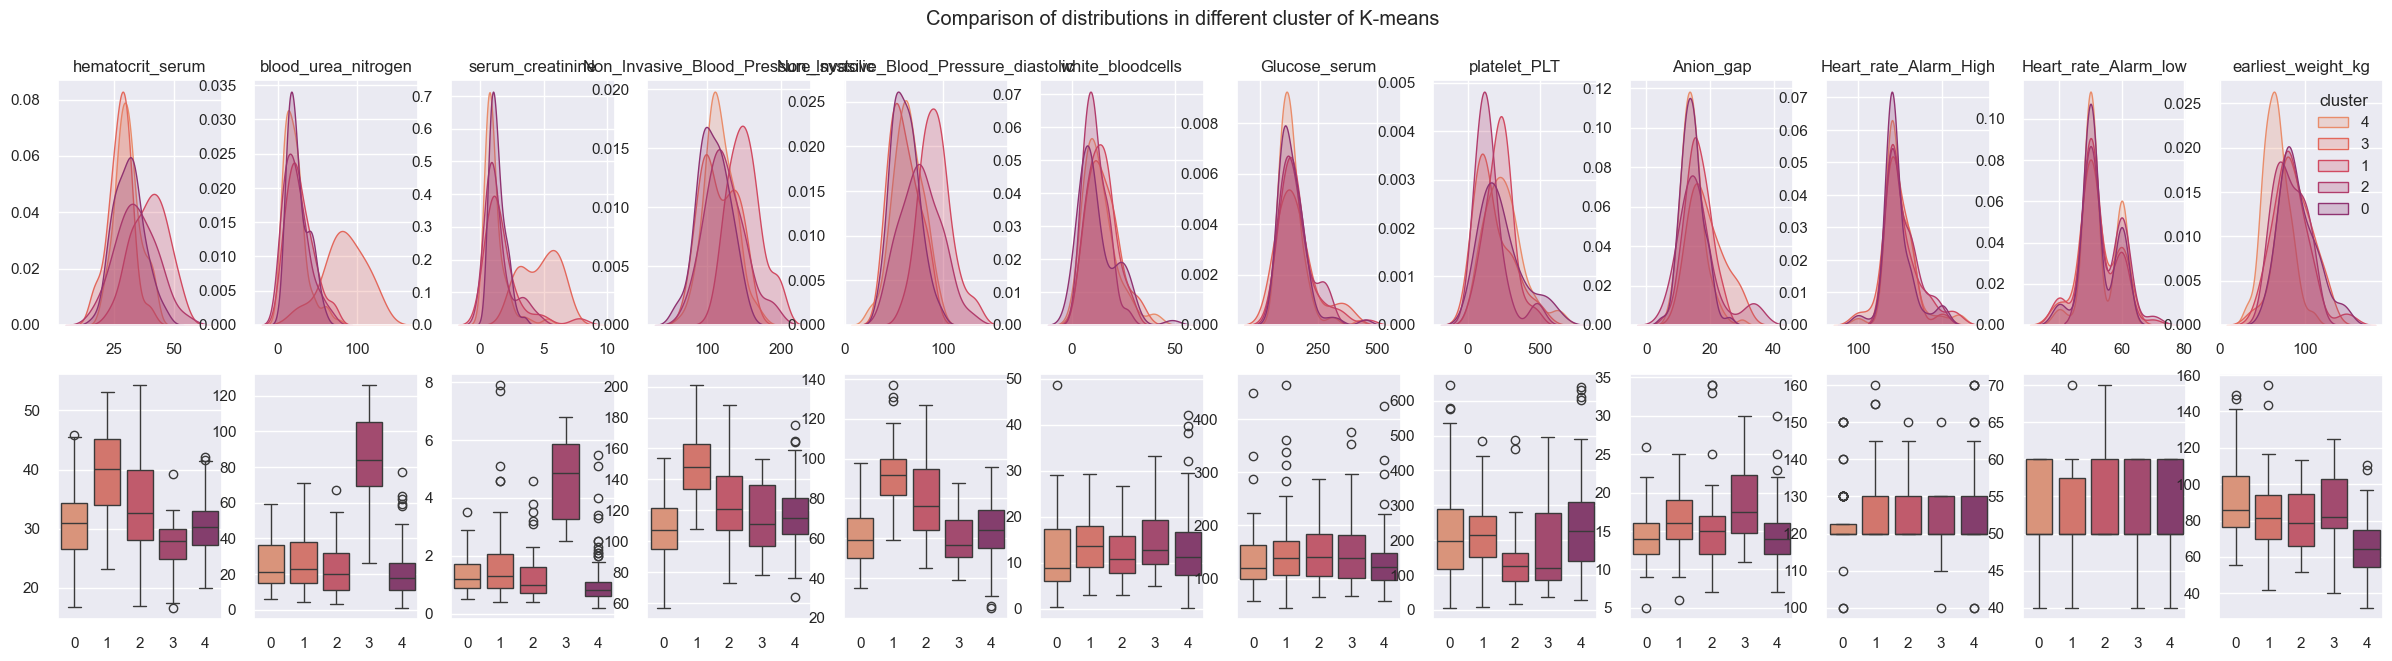

{'hematocrit_serum': 0.00745653044716759,
 'blood_urea_nitrogen': 5.593400806886425e-31,
 'serum_creatinine': 1.8591747410050583e-29,
 'Non_Invasive_Blood_Pressure_systolic': 0.8539500747171189,
 'Non_Invasive_Blood_Pressure_diastolic': 0.2764645409082351,
 'white_bloodcells': 0.38654988756414965,
 'Glucose_serum': 0.11154179910259993,
 'platelet_PLT': 0.020800733335567076,
 'Anion_gap': 5.6828182395266925e-06,
 'Heart_rate_Alarm_High': 0.336822291539302,
 'Heart_rate_Alarm_low': 0.5522531079086427,
 'earliest_weight_kg': 1.6902699006565696e-08}

In [433]:
plot_mean_difference(df_clean, 'cluster', "Comparison of distributions in different cluster of K-means", colours=palette, features_kde=features_kde)

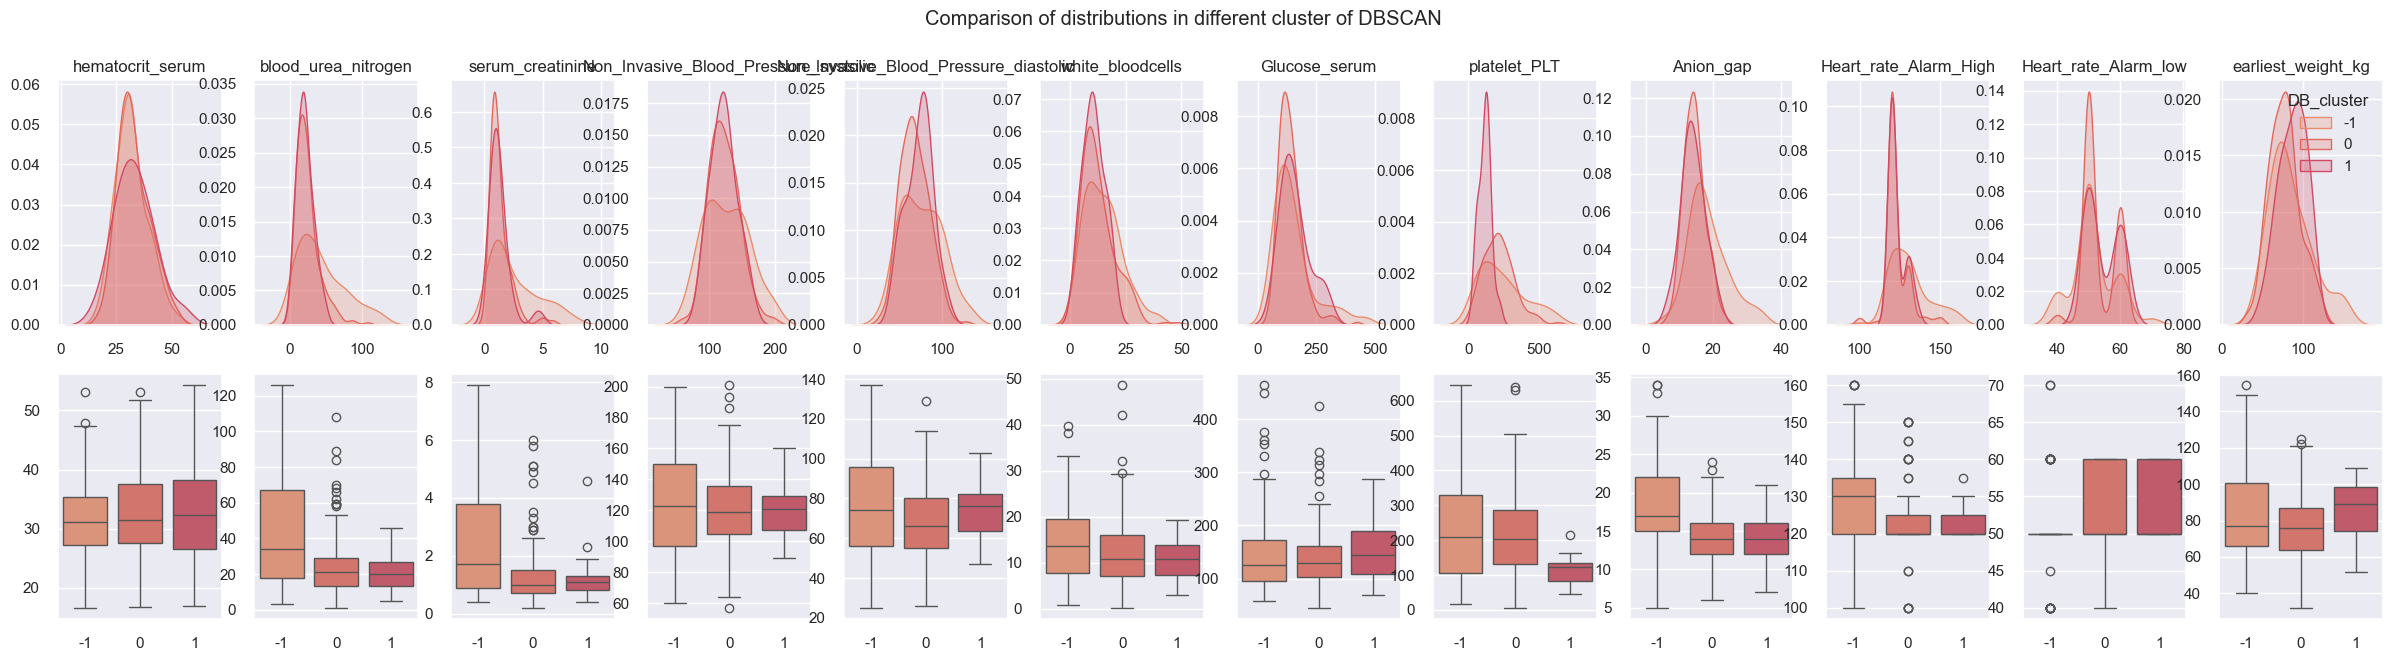

{'hematocrit_serum': 0.3144591711230802,
 'blood_urea_nitrogen': 3.1255183551953457e-09,
 'serum_creatinine': 1.4176840251038524e-10,
 'Non_Invasive_Blood_Pressure_systolic': 0.30473645330103716,
 'Non_Invasive_Blood_Pressure_diastolic': 0.0025609208116035755,
 'white_bloodcells': 0.04133952888787795,
 'Glucose_serum': 0.1182121972054671,
 'platelet_PLT': 0.12982877868688641,
 'Anion_gap': 1.128436544750567e-11,
 'Heart_rate_Alarm_High': 3.877746361195469e-09,
 'Heart_rate_Alarm_low': 0.033193372301405615,
 'earliest_weight_kg': 0.009888031928523335}

In [434]:
plot_mean_difference(df_clean, 'DB_cluster', "Comparison of distributions in different cluster of DBSCAN", colours=palette, features_kde=features_kde)

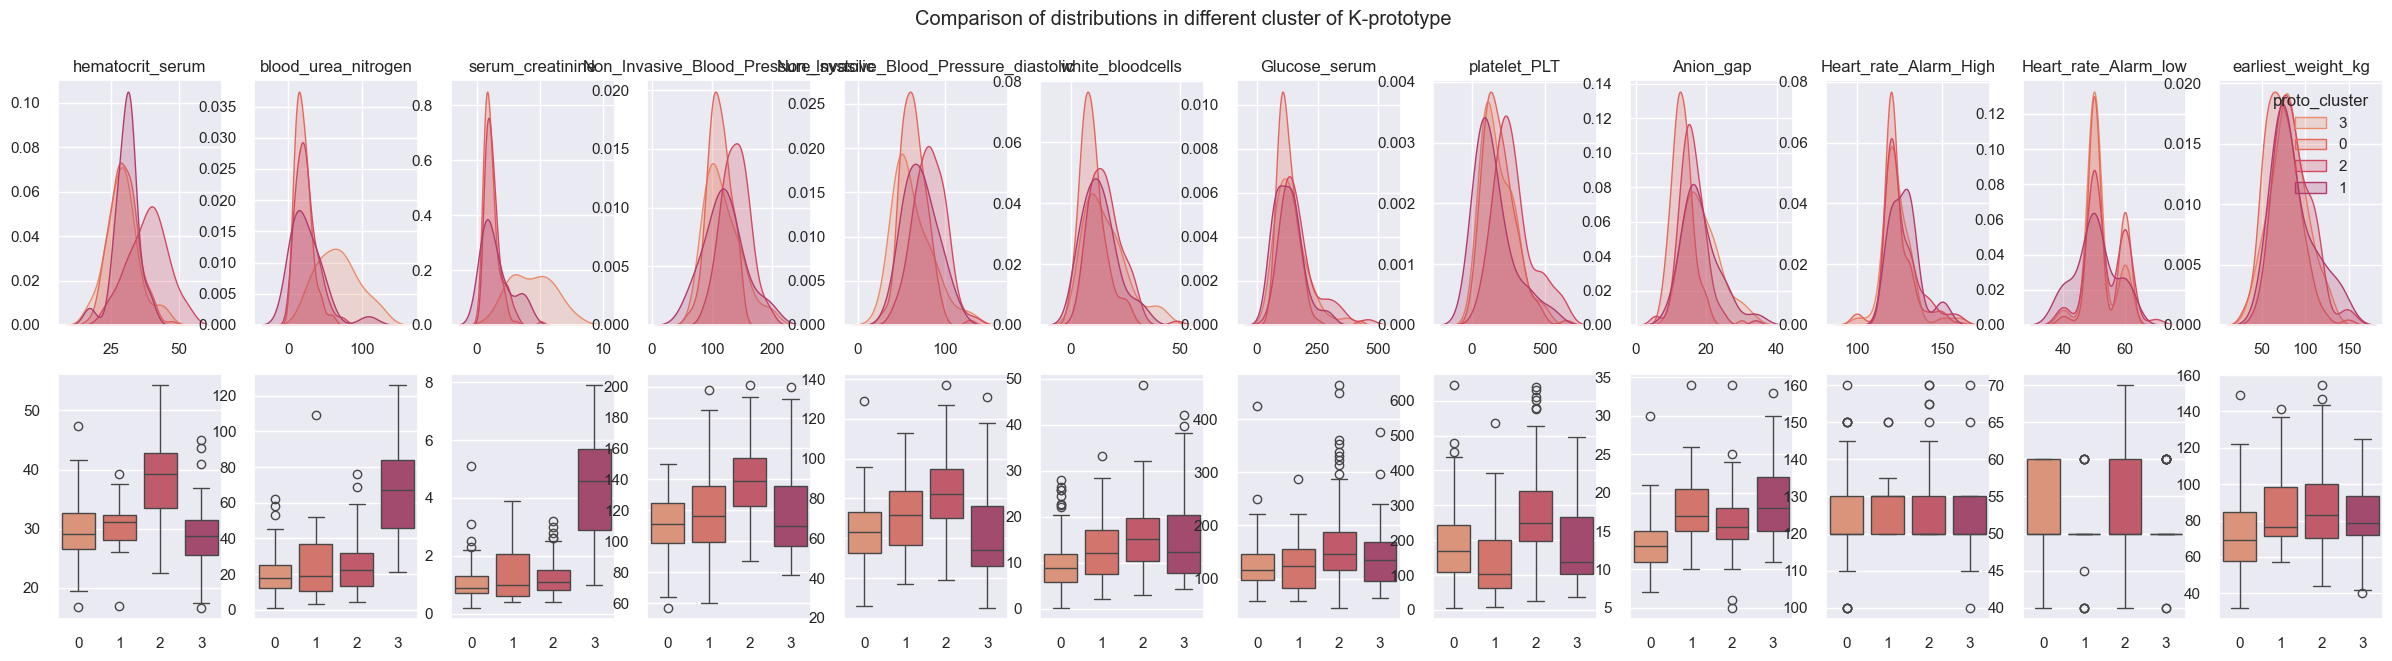

{'hematocrit_serum': 0.6044313227002881,
 'blood_urea_nitrogen': 2.3128523921380702e-32,
 'serum_creatinine': 1.111353001699342e-39,
 'Non_Invasive_Blood_Pressure_systolic': 0.1215215337013965,
 'Non_Invasive_Blood_Pressure_diastolic': 0.7650409290259,
 'white_bloodcells': 5.75823446164728e-06,
 'Glucose_serum': 0.11143500661239039,
 'platelet_PLT': 0.782511747817761,
 'Anion_gap': 5.91313447233723e-14,
 'Heart_rate_Alarm_High': 0.9060638309079201,
 'Heart_rate_Alarm_low': 0.1130396542093924,
 'earliest_weight_kg': 0.02521151718936905}

In [435]:
plot_mean_difference(df_clean, 'proto_cluster', "Comparison of distributions in different cluster of K-prototype", colours=palette, features_kde=features_kde)

## Mortality rate

In [392]:
def plot_mortality(label):
    mortality_cluster = []
    x_ax = []
    for c in sorted(df_clean[label].unique()):
        sub = df_clean[df_clean[label] == c]
        mortality_cluster.append(100 * len(sub[sub.mortality == 'Dead']) / df_clean.mortality.value_counts()['Dead'])
        x_ax.append(c)

    plt.bar(x_ax, mortality_cluster, color=palette)
    plt.axhline(y=round(100* len(df_clean[df_clean.mortality == 'Dead']) / len(df_clean),2), color='red', linestyle='--', linewidth=2, label='Mortality rate')
    plt.annotate('Overall 19.84%', xy=(0, 20), xytext=(2.5, 21))

    for c, rate in zip(x_ax, mortality_cluster):
        plt.text(c, rate + 1, f'{rate:.2f}%', ha='center', va='bottom')

    plt.xlabel("Cluster")
    plt.ylim([0,100])

def scatter_plot(label):
    for cluster in X_pca[label].unique():
        cluster_data = X_pca[X_pca[label] == cluster]
        plt.scatter(cluster_data['PC1'], cluster_data['PC2'], label=f'cluster {cluster}', color=palette[cluster])
    plt.xlabel('PC1')

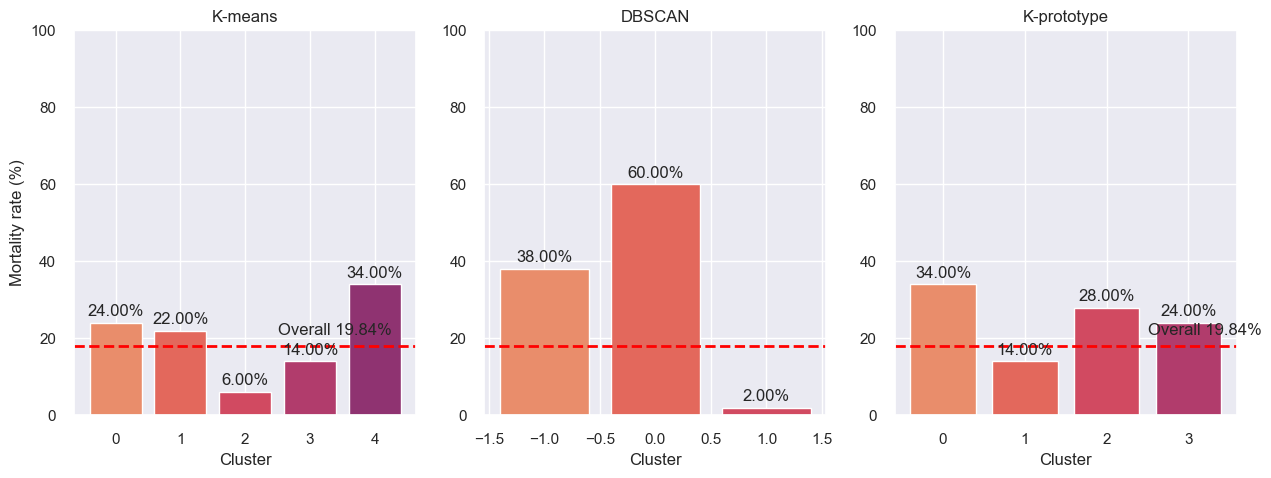

In [436]:
# Mortality rate in each cluster
plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plot_mortality('cluster')
plt.ylabel("Mortality rate (%)")
plt.title("K-means")

plt.subplot(1,3,2)
plot_mortality('DB_cluster')
plt.title("DBSCAN")

plt.subplot(1,3,3)
plot_mortality('proto_cluster')
plt.title("K-prototype")

plt.show()

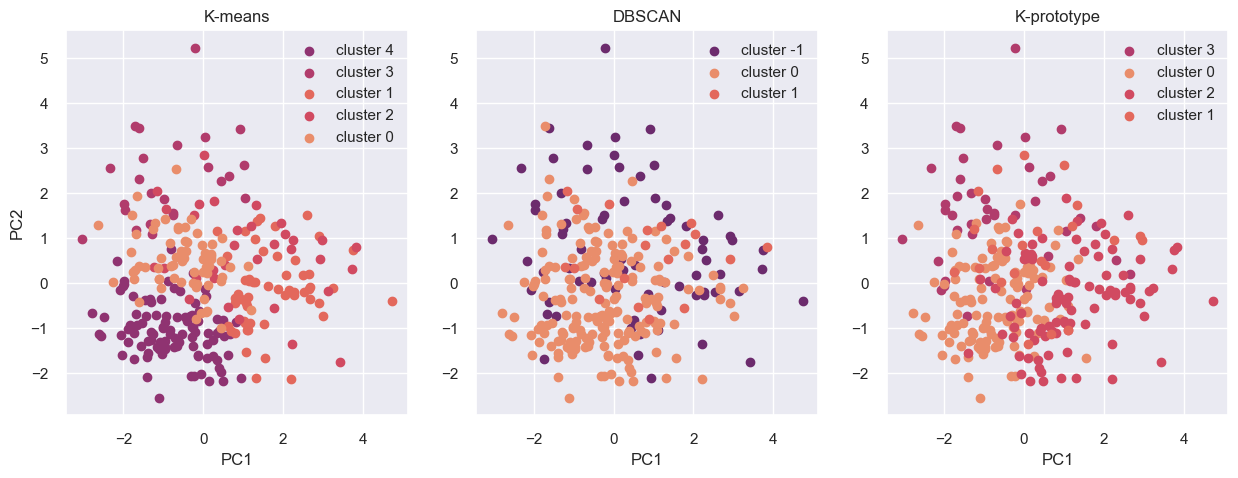

In [437]:
plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
scatter_plot('cluster')
plt.ylabel('PC2')
plt.title("K-means")
plt.legend()

plt.subplot(1,3,2)
scatter_plot('DB_cluster')
plt.title("DBSCAN")
plt.legend()

plt.subplot(1,3,3)
scatter_plot('proto_cluster')
plt.title("K-prototype")
plt.legend()

In [513]:
fig = px.scatter_3d(X_pca, x='PC1', y='PC2', z='PC3',
              color='cluster', title="K-means", color_discrete_sequence=palette)
fig.show()

In [512]:
fig = px.scatter_3d(X_pca, x='PC1', y='PC2', z='PC3',
              color='DB_cluster', title="DBSCAN", color_discrete_sequence=palette)
fig.show()

In [511]:
fig = px.scatter_3d(X_pca, x='PC1', y='PC2', z='PC3',
              color='proto_cluster', title="K-prototype", color_discrete_sequence=palette)
fig.show()